# DSPy - Advanced Prompt Engineering

1. Breakout Room #1:
  - Task 1: Dependencies
  - Task 2: Loading Our Model
  - Task 3: Loading Our Data
  - Task 4: Setting Our Signature
  - Task 5: Creating a Predictor
  - Task 6: Making a Chain, I mean...Module
  - Task 7: Evaluate
  - Task 8: Program Optimization
2. Breakout Room #2:
  - Task 1: Defining Appliation
  - Task 2: Hyper-Parameters and Data
  - Task 3: Signature And Module Creation
  - Task 4: Evaluating Our LongFormQA Module
  - Task 5: Adding Assertions

---

In the following notebook, we'll explore an introduction to DSPy and what it can do in just a few lines of code!

# 🤝 Breakout Room #1

## Task 1: Dependencies

We'll start by installing DSPy, `nltk` (for later) and including our OpenAI API key.

In [1]:
!pip install -qU dspy-ai nltk

DSPy can leverage OpenAI's models under the hood, and still provide an advantage - in order to do so, however, we'll need to provide an OpenAI API Key!

In [2]:
import os
import getpass

os.environ['OPENAI_API_KEY'] = getpass.getpass('OpenAI API Key: ')

## Task 2: Loading Our Model

Now we can setup our OpenAI language model - which we'll use through the remaining cells in the notebook.

In [3]:
from dspy import LM

llm = LM(model='openai/gpt-3.5-turbo')

/Users/gmedrano/Docs/skowak/apps/ai-bootcamp-apps/aie4-bootcamp/bootcamp-lessons/AIE4/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Similar to other libraries, we can call the LLM directly with a string to get a response!

In [4]:
llm("What is the square root of pi?")

['The square root of pi is approximately 1.77245385091.']

We'll also set our `setting.configure` with our OpenAI model in the `lm` (Language Model) field for a default LM to use in case we don't specify which LM we'd like to use when calling our DSPy `Predictors`.

In [5]:
import dspy

dspy.settings.configure(lm=llm)

## Task 3: Load Our Data

We're going to be using a dataset that provides a number of example sentences, along with a rating that indicates their "dopeness" level.

In [6]:
from datasets import load_dataset

dataset = load_dataset("llm-wizard/dope_or_nope_v2")

Generating train split: 100%|██████████| 99/99 [00:00<00:00, 9469.03 examples/s]


We have a total of 99 rows of data, and will be splitting that into a `trainset` and a `valset` - for training and evaluation.

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Sentence', 'Rating', 'Fire Emojis'],
        num_rows: 99
    })
})

Due to the nature of the dataset, we'll need to shuffle our dataset to ensure our labels are not clumped up, and our `valset` is remotely representative to our `trainset`.

In [8]:
dataset = dataset.shuffle(seed=42)

We'll move our `Dataset` into the expected format in DSPy which is the [`Example`](https://dspy-docs.vercel.app/docs/deep-dive/data-handling/examples)!


Our examples will have two keys:

- `sentence`, our input sentence to be rated
- `rating`, our rating label

We'll specify our input as `sentence` to properly leverage the DSPy framework.

In [9]:
from dspy import Example

trainset = []

for row in dataset["train"].select(range(0,len(dataset["train"])-10)):
  trainset.append(Example(sentence=row["Sentence"], rating=row["Rating"]).with_inputs("sentence"))

len(trainset)

89

We'll repeat the same process for our `valset` as well.

In [10]:
valset = []

for row in dataset["train"].select(range(len(trainset),len(dataset["train"]))):
  valset.append(Example(sentence=row["Sentence"], rating=row["Rating"]).with_inputs("sentence"))

len(valset)

10

Let's take a peek at an example from our `trainset` and `valset`!

In [11]:
train_example = trainset[0]
print(f"Sentence: {train_example.sentence}")
print(f"Label: {train_example.rating}")

Sentence: The results were satisfactory.
Label: 0


In [12]:
valset_example = valset[0]
print(f"Sentence: {valset_example.sentence}")
print(f"Label: {valset_example.rating}")

Sentence: This is top tier.
Label: 4


## Task 4: Setting Our Signature

The first foundational unit in DSPy is the `Signature`.

In a sense, a `Signature` can be thought of as both a prompt, as well as metadata about that prompt.

Going beyond just a simple `SystemMessage`, as seen in other frameworks, the `Signature` helps DSPy validate datatypes, create examples, and more.

> NOTE: DSPy's [documentation](https://dspy-docs.vercel.app/docs/deep-dive/signature/understanding-signatures#what-is-a-signature) goes into more detail about what exactly a `Signature` is.

In [13]:
from dspy import Signature, InputField, OutputField

class DopeOrNopeSignature(Signature):
  """Rate a sentence from 0 to 4 on a dopeness scale"""
  sentence: str = InputField()
  rating: int = OutputField()

## Task 5: Creating a Predictor

Now that we have our `Signature`, we can build a `Predictor` that leverages it.

A `Predictor`, in the simplest terms, is what calls the LLM using our signature. Importantly, the `Predictor` knows how to leverage our signature to call the LLM. From DSPy's documentation, one of the most interesting parts of a `Predictor` is that it can *learn* to become better at the desired task!

Let's take a look at our `TypedPredictor` below to see more.

In [14]:
from dspy.functional import TypedPredictor

generate_label = TypedPredictor(DopeOrNopeSignature)

In [15]:
generate_label

TypedPredictor(DopeOrNopeSignature(sentence -> rating
    instructions='Rate a sentence from 0 to 4 on a dopeness scale'
    sentence = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'input', 'prefix': 'Sentence:', 'desc': '${sentence}'})
    rating = Field(annotation=int required=True json_schema_extra={'__dspy_field_type': 'output', 'prefix': 'Rating:', 'desc': '${rating}'})
))

In [17]:
label_prediction = generate_label(sentence=valset_example.sentence)
print(f"Sentence: {valset_example.sentence}")
print(f"Prediction: {label_prediction}")

Sentence: This is top tier.
Prediction: Prediction(
    rating=4
)


We can, at any time, check our LLMs outputs through the `inspect_history`.

In [18]:
llm.inspect_history(n=1)





System message:

Your input fields are:
1. `sentence` (str)

Your output fields are:
1. `rating` (int): ${rating} (Respond with a single int value)

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## sentence ## ]]
{sentence}

[[ ## rating ## ]]
{rating}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        Rate a sentence from 0 to 4 on a dopeness scale


User message:

[[ ## sentence ## ]]
This is top tier.

Respond with the corresponding output fields, starting with the field `rating`, and then ending with the marker for `completed`.


Response:

[[ ## rating ## ]]
4
[[ ## completed ## ]]







Notice how, without our input - the `TypedPredictor` has included format instructions to the LLM to help ensure our returned data resembles what we desire.

Let's look at another example of a `Predictor` - this time with Chain of Thought.

In order to use this - we don't have to do anything with our `Signature`! We can leave it exactly as is - and allow the `Predictor` to adapt to it.

> NOTE: We won't be using this predictor going forward - this is just to showcase the ease of using another `Predictor` with a `Signature`.

In [19]:
from dspy.functional import TypedChainOfThought

generate_label_with_chain_of_thought = TypedChainOfThought(DopeOrNopeSignature)

label_prediction = generate_label_with_chain_of_thought(sentence=valset_example.sentence)

In [22]:
print(f"Sentence: {valset_example.sentence}")
print(f"Reasoning: {label_prediction.reasoning}")
print(f"Ground Truth Label: {valset_example.rating}")
print(f"Prediction: {label_prediction.rating}")

Sentence: This is top tier.
Reasoning: I would rate this sentence as a 4 because it conveys a high level of excellence or superiority.
Ground Truth Label: 4
Prediction: 4


We can, again, check our LLM's history to see what the actual prompt/response is.


In [23]:
llm.inspect_history(n=1)





System message:

Your input fields are:
1. `sentence` (str)

Your output fields are:
1. `reasoning` (str): ${produce the rating}. We ...
2. `rating` (int): ${rating} (Respond with a single int value)

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## sentence ## ]]
{sentence}

[[ ## reasoning ## ]]
{reasoning}

[[ ## rating ## ]]
{rating}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        Rate a sentence from 0 to 4 on a dopeness scale


User message:

[[ ## sentence ## ]]
This is top tier.

Respond with the corresponding output fields, starting with the field `reasoning`, then `rating`, and then ending with the marker for `completed`.


Response:

[[ ## reasoning ## ]]
I would rate this sentence as a 4 because it conveys a high level of excellence or superiority. 

[[ ## rating ## ]]
4

[[ ## completed ## ]]







## Task 6: Making a Chain, I mean...Module.

Now that we have our `TypedPredictor`, we can create a `Module`!

A `Module` is useful because it allows us to interact with the `Predictor` and `Signature` in a way that DSPy can leverage for optimization.

The helps the DSPy framework determine paths through your program - and helps during the `compilation` or optimisation steps (formerly `teleprompting`).

> NOTE: You might notice this looks strikingly familiar to PyTorch, and this is by design!

In [24]:
from dspy import Module, Prediction

class DopeOrNopeStudent(Module):
  def __init__(self):
    super().__init__()

    self.generate_rating = TypedPredictor(DopeOrNopeSignature)

  def forward(self, sentence):
    prediction = self.generate_rating(sentence=sentence)
    return Prediction(rating=prediction.rating)

## Task 7: Evaluate

As with any good framework, DSPy has the ability to `Evaluate` - we can leverage this to determine how our current DSPy "program" (our `Module` in this case) operates.

> NOTE: DSPy's "program" could be loosely related to a "chain" from the popular LLM Framework LangChain.

In [25]:
from dspy.evaluate.evaluate import Evaluate

evaluate_fewshot = Evaluate(devset=valset, num_threads=1, display_progress=True, display_table=10)

def exact_match_metric(answer, pred, trace=None):
  return answer.rating == pred.rating

evaluate_fewshot(DopeOrNopeStudent(), metric=exact_match_metric)

Average Metric: 6 / 10  (60.0): 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


,sentence,example_rating,pred_rating,exact_match_metric
0,This is top tier.,4,4,✔️ [True]
1,Big mood.,3,3,✔️ [True]
2,The presentation was outstanding.,1,4,
3,I'm living my best life.,4,4,✔️ [True]
4,"Sksksksk, that's hilarious.",3,3,✔️ [True]
5,The report is comprehensive.,1,3,
6,This is next level.,4,4,✔️ [True]
7,The meeting was productive.,1,3,
8,The analysis was insightful.,1,3,
9,I stan a legend.,3,3,✔️ [True]


60.0

#### ❓Question #1:

Does DSPy lend itself to more complex less exactly defined evaluations? Provide reasoning for your answer.
#### Answer:
Yes, DSPy is designed to handle complex evaluations beyond simple exact matches. It allows for custom metrics and supports evaluations that involve reasoning, open-ended answers, or partial correctness. By using custom evaluation functions and metrics, we can assess the performance of language model programs on tasks where the correctness is not strictly defined, such as summarization, translation, or creative writing.

## Task 8: Program Optimization (the Artist Formerly Known as Teleprompting)

Optimization is the crux of the DSPy framework - it is what allows it to operate at a level beyond traditional prompt engineering.

At a high level, optimisation is a way for the DSPy framework to take the program, a training set, and a metric - and make changes/tweaks to our program to improve our metrics on our dataset.

Let's get started with the `LabeledFewShot` optimizer.

The `LabeledFewShot` optimizer very simply provides a sample of the `trainset` as few-shot examples!

In [26]:
from dspy.teleprompt import LabeledFewShot

labeled_fewshot_optimizer = LabeledFewShot(k=4)

Once we define our optimizer, we can compile our program!

In [27]:
compiled_dspy = labeled_fewshot_optimizer.compile(student=DopeOrNopeStudent(), trainset=trainset)

Let's evaluate!

In [29]:
evaluate_fewshot(compiled_dspy, metric=exact_match_metric)

Average Metric: 4 / 10  (40.0): 100%|██████████| 10/10 [00:00<00:00, 259.11it/s]


,sentence,example_rating,pred_rating,exact_match_metric
0,This is top tier.,4,4,✔️ [True]
1,Big mood.,3,3,✔️ [True]
2,The presentation was outstanding.,1,3,
3,I'm living my best life.,4,3,
4,"Sksksksk, that's hilarious.",3,3,✔️ [True]
5,The report is comprehensive.,1,2,
6,This is next level.,4,3,
7,The meeting was productive.,1,3,
8,The analysis was insightful.,1,3,
9,I stan a legend.,3,3,✔️ [True]


40.0

As you can see - with no effort at all - we can improve our performance on our `valset`!

Let's try another optimizer - this time: [`BootstrapFewShot`](https://dspy-docs.vercel.app/docs/deep-dive/teleprompter/bootstrap-fewshot).

The key thing to note is that this optimizer works with even very few examples - by way of generating new examples by the LLMs!

In [32]:
from dspy.teleprompt import BootstrapFewShot

optimizer = BootstrapFewShot(metric=exact_match_metric, max_bootstrapped_demos=8, max_labeled_demos=12)

compiled_dspy_BOOTSTRAP = optimizer.compile(student=DopeOrNopeStudent(), trainset=trainset)

 12%|█▏        | 11/89 [00:03<00:26,  2.95it/s]

Bootstrapped 8 full traces after 12 examples in round 0.


#### 🏗️ Activity #1:

Outline how `BootstrapFewShot` works "under the hood" in natural language or create a diagram of the workflow.

#### Answer:
1. Initialize BootstrapFewShot
Set up the BootstrapFewShot instance with specific parameters such as the evaluation metric, maximum number of bootstrapped examples, and maximum number of labeled examples.

2. Prepare Seed Examples (Few-Shot Examples)
Create a small set of manually crafted examples that demonstrate the desired input-output behavior for the task.

3. Compile BootstrapFewShot with Seed Examples
Use the compile method to integrate the seed examples into the BootstrapFewShot instance, preparing it for generating additional examples.

4. Generate Additional Prompt-Response Pairs
The BootstrapFewShot mechanism uses the seed examples to generate new prompt-response pairs by leveraging the language model’s ability to create variations based on the initial data.

5. Evaluate Generated Responses
Assess the quality of the newly generated responses using the specified evaluation metric (e.g., exact match). Determine if they meet the desired criteria.

6. Refine Prompts if Necessary
If any generated responses do not meet the evaluation criteria, adjust or rephrase the prompts to improve the quality of future responses.

7. Store Successful Prompt-Response Pairs
Save the prompt-response pairs that successfully meet the evaluation criteria for future reference and use in optimizing the TypedPredictor.

8. Iterate Until Completion
Continue generating, evaluating, refining, and storing prompt-response pairs until the maximum number of bootstrapped examples is reached or the desired performance level is achieved.

9. Finalize and Utilize Bootstrapped Examples
Once the bootstrapping process is complete, use the compiled set of prompt-response pairs to enhance the TypedPredictor’s ability to generate accurate and consistent responses in future tasks. A final response can then be sent to the user.

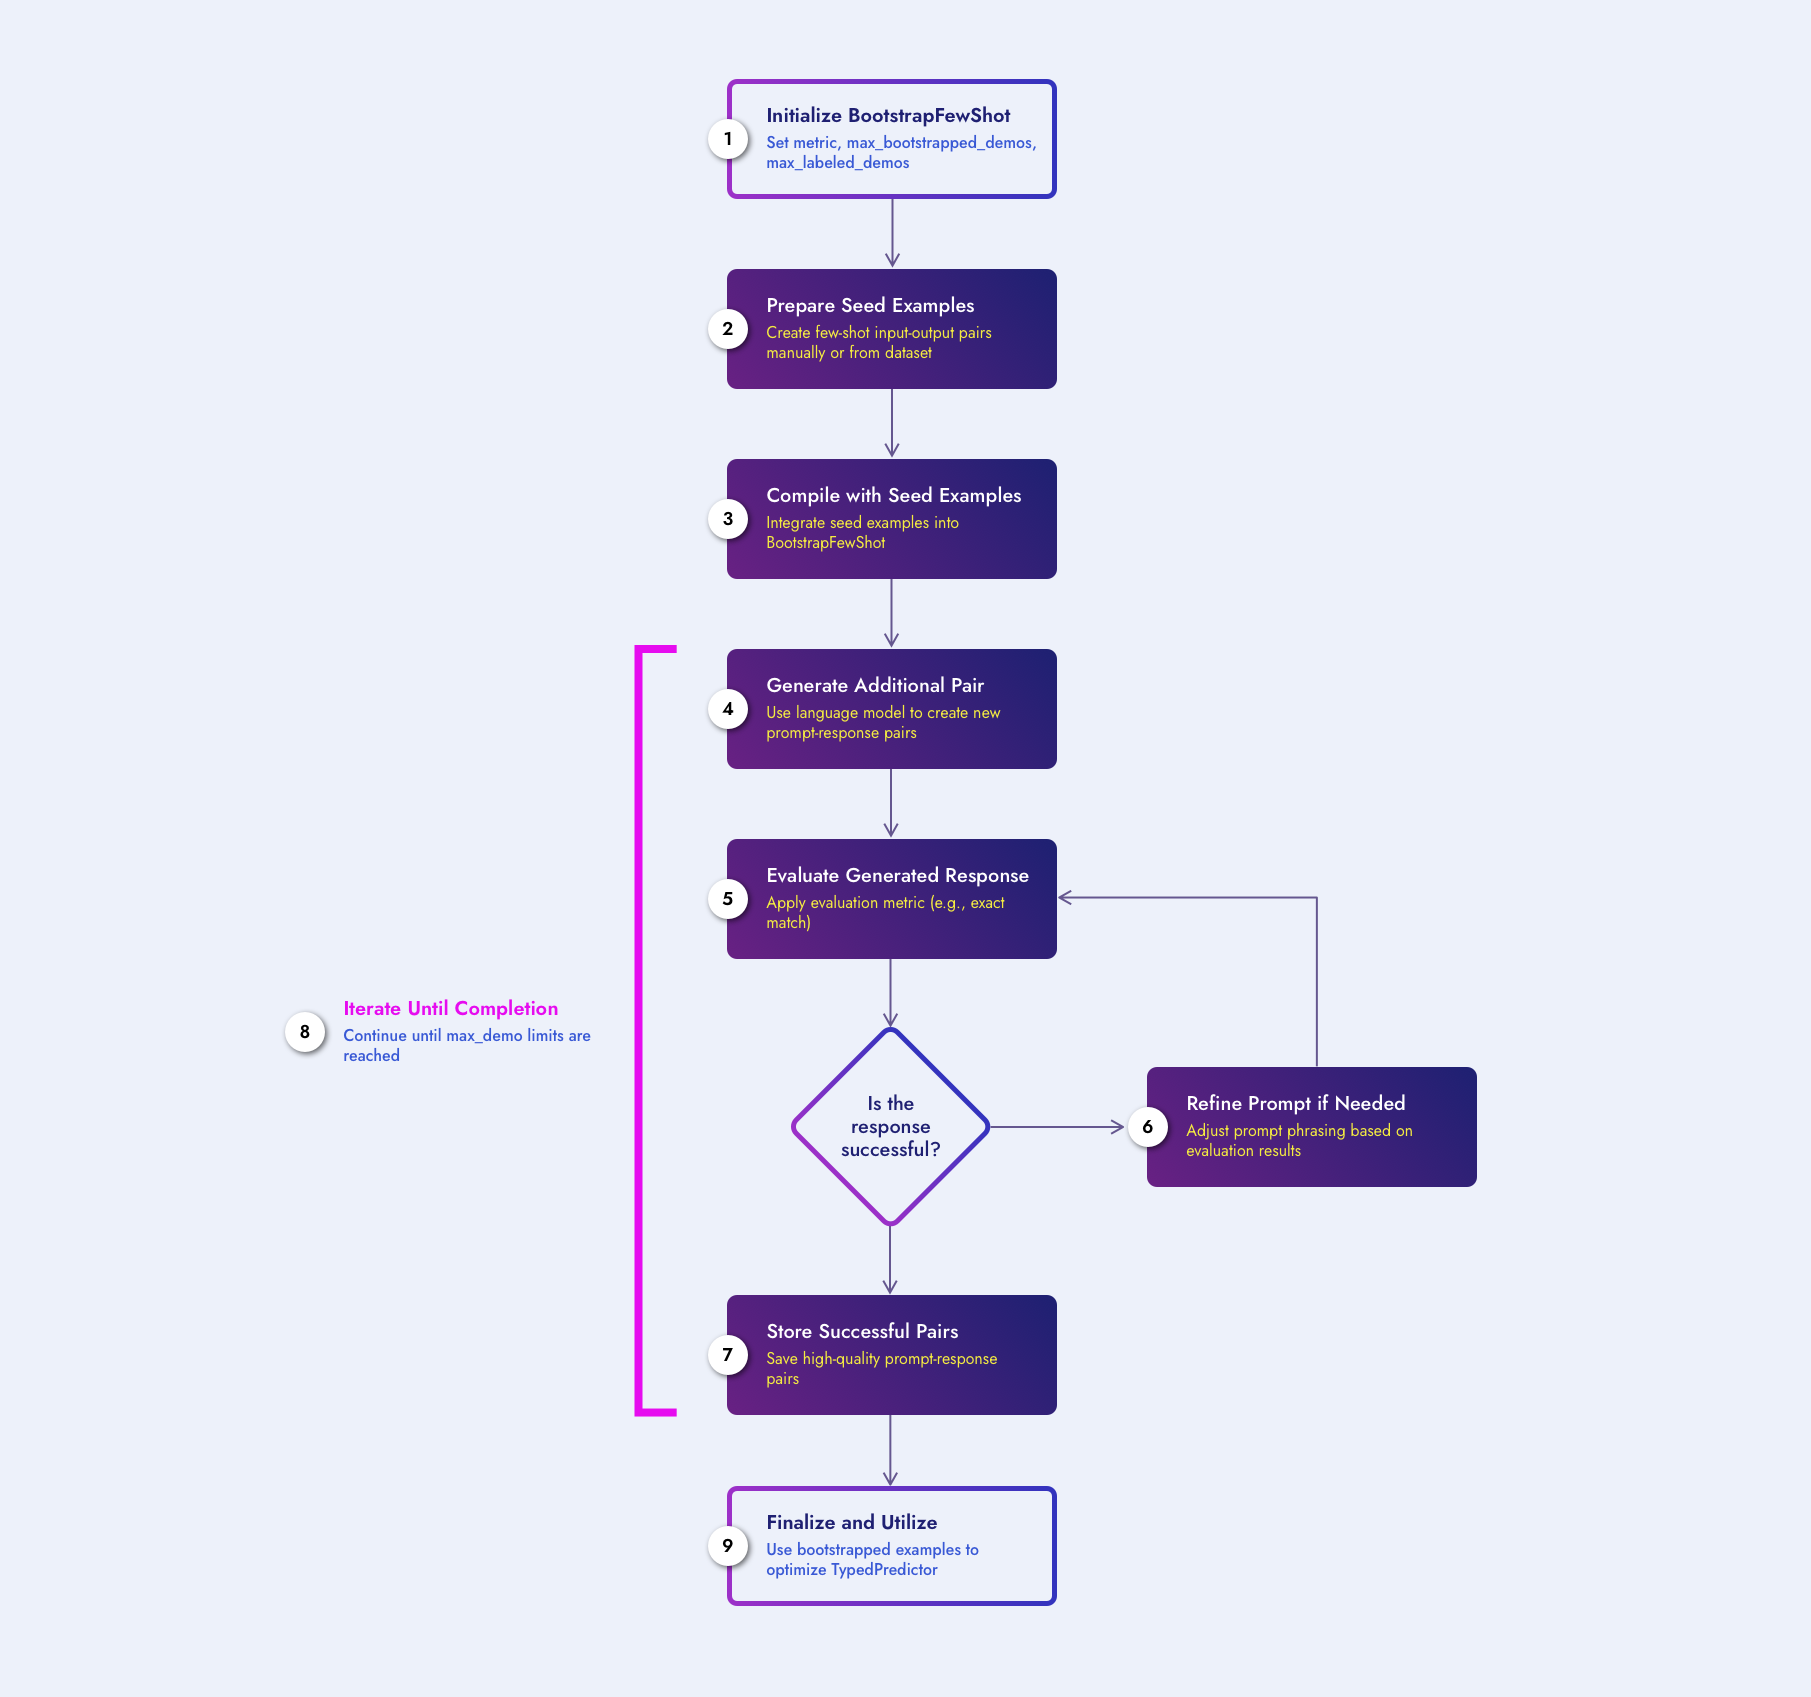

Let's finally evaluate!

In [33]:
evaluate_fewshot(compiled_dspy_BOOTSTRAP, metric=exact_match_metric)

Average Metric: 8 / 10  (80.0): 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


,sentence,example_rating,pred_rating,exact_match_metric
0,This is top tier.,4,4,✔️ [True]
1,Big mood.,3,4,
2,The presentation was outstanding.,1,1,✔️ [True]
3,I'm living my best life.,4,4,✔️ [True]
4,"Sksksksk, that's hilarious.",3,3,✔️ [True]
5,The report is comprehensive.,1,1,✔️ [True]
6,This is next level.,4,4,✔️ [True]
7,The meeting was productive.,1,1,✔️ [True]
8,The analysis was insightful.,1,1,✔️ [True]
9,I stan a legend.,3,4,


80.0

We can see that this optimization helps our program achieve 30 points higher on our evaluation!

In [34]:
llm.inspect_history(n=1)





System message:

Your input fields are:
1. `sentence` (str)

Your output fields are:
1. `rating` (int): ${rating} (Respond with a single int value)

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## sentence ## ]]
{sentence}

[[ ## rating ## ]]
{rating}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        Rate a sentence from 0 to 4 on a dopeness scale


User message:

[[ ## sentence ## ]]
This tea is piping hot.

Respond with the corresponding output fields, starting with the field `rating`, and then ending with the marker for `completed`.


Assistant message:

[[ ## rating ## ]]
4

[[ ## completed ## ]]


User message:

[[ ## sentence ## ]]
Your professionalism is appreciated.

Respond with the corresponding output fields, starting with the field `rating`, and then ending with the marker for `completed`.


Assistant message:

[[ ## rating ## ]]
1

[[ ## completed ## ]]


User message:

[[ ## sente

In [35]:
for name, parameter in compiled_dspy_BOOTSTRAP.named_parameters():
  print(f"Parameter {name}: Num Examples: {len(parameter.demos)}, {parameter.demos[0]}")
  print()

Parameter generate_rating.predictor: Num Examples: 12, Example({'augmented': True, 'sentence': 'This tea is piping hot.', 'rating': '4'}) (input_keys=None)



# 🤝 Breakout Room #2

## Task 1: Defining Application

In this breakoutroom, we'll be using DSPy to optimize a Multi-Hop QA module with `Assertions`.

So what is a "Multi-Hop QA module"?

Well - going beyond naive RAG retrieval, Multi-Hop QA lets us create applications that are well-suited to questions that (potentially have) multiple "hops" required to answer them.

For instance: "Who is the top goal scorer that has ever played on the Winnipeg Jets, and what years did he play for the Winnipeg Jets?"

You can see that there are two "hops" required to respond correctly:

1. Who is the top goal scorer for the Winnipeg Jets?
2. What years did X player play for the Winnipeg Jets?

While this is a toy example, the idea is the same across complexity: Questions that take more than one step of reasoning to answer.

Let's grab some data, set-up some hyper-parameters, and then get to implmentation!

## Task 2: Hyper-Parameters and Data

We'll use the DSPy ColBERT abstracts as our retrieval system for this example.

We'll also use `GPT-4o-Mini` as our LM to keep things light and inexpensive as we'll be sending quite a few LLM calls.

In [36]:
colbertv2_wiki17_abstracts = dspy.ColBERTv2(url='http://20.102.90.50:2017/wiki17_abstracts')
dspy.settings.configure(rm=colbertv2_wiki17_abstracts)
lm_openai_four_mini = dspy.LM(model='openai/gpt-4o-mini', max_tokens=500)
dspy.settings.configure(lm=lm_openai_four_mini, trace=[], temperature=0.7)

We'll be using the [`HotPotQA`](https://hotpotqa.github.io/) dataset which is a number of multi-hop QA pairs that includes context, and is based on Wikipedia (for compatibility with our Retriever system).

In [37]:
from dspy.datasets import HotPotQA

dataset = HotPotQA(train_seed=1, train_size=20, eval_seed=2023, dev_size=50, test_size=0, keep_details=True)
trainset = [x.with_inputs('question') for x in dataset.train]
devset = [x.with_inputs('question') for x in dataset.dev]

Generating test split: 100%|██████████| 7405/7405 [00:01<00:00, 3732.10 examples/s]


We can look at a few examples:

In [38]:
train_example = trainset[0]
print(f"Question: {train_example.question}")
print(f"Answer: {train_example.answer}")
print(f"Relevant Wikipedia Titles: {train_example.gold_titles}")

Question: At My Window was released by which American singer-songwriter?
Answer: John Townes Van Zandt
Relevant Wikipedia Titles: {'Townes Van Zandt', 'At My Window (album)'}


In [39]:
dev_example = devset[18]
print(f"Question: {dev_example.question}")
print(f"Answer: {dev_example.answer}")
print(f"Relevant Wikipedia Titles: {dev_example.gold_titles}")

Question: What is the nationality of the chef and restaurateur featured in Restaurant: Impossible?
Answer: English
Relevant Wikipedia Titles: {'Restaurant: Impossible', 'Robert Irvine'}


## Task 3: Signature and Module Creation

As we learned above - the bread and butter for DSPy is the `Signature` and `Module`, so we'll create each below.

For our `Signatures`, things are fairly straight-forward, we need to:

1. Create a `Signature` that will allow us to generate sub-questions.
2. Create a `Signature` that will provide citations for our responses.

In [40]:
from dsp.utils import deduplicate

class GenerateSearchQuery(dspy.Signature):
    """Write a simple search query that will help answer a complex question."""
    context = dspy.InputField(desc="may contain relevant facts")
    question = dspy.InputField()
    query = dspy.OutputField()

class GenerateCitedParagraph(dspy.Signature):
    """Generate a paragraph with citations."""
    context = dspy.InputField(desc="may contain relevant facts")
    question = dspy.InputField()
    paragraph = dspy.OutputField(desc="includes citations")

Our `Module` is a bit more complex than what we've seen before - so let's walk through what's happening inside of it. We're going to concern ourselves with the `forward` method - as that is where the logic of our `Module` is contained.

In the `forward` method we:

1. Create an empty list of contexts.
2. For each `hop` in our `max_hops` (by default, it will be 2) we:
  - Generate a new `query` using our `GenerateSearchQuery` with a `ChainOfThought` predictor.
  - Retrieve a number (default 3) of `passages` based on that new `query`.
  - Add unique (non-present) `passages` into our `context` list.
3. Take all that `context` and our original `question` and generate a cited paragraph and use it to predict an answer.

In [41]:
class LongFormQA(dspy.Module):
    def __init__(self, passages_per_hop=3, max_hops=2):
        super().__init__()
        self.generate_query = [dspy.ChainOfThought(GenerateSearchQuery) for _ in range(max_hops)]
        self.retrieve = dspy.Retrieve(k=passages_per_hop)
        self.generate_cited_paragraph = dspy.ChainOfThought(GenerateCitedParagraph)
        self.max_hops = max_hops

    def forward(self, question):
        context = []
        for hop in range(self.max_hops):
            query = self.generate_query[hop](context=context, question=question).query
            passages = self.retrieve(query).passages
            context = deduplicate(context + passages)
        pred = self.generate_cited_paragraph(context=context, question=question)
        pred = dspy.Prediction(context=context, paragraph=pred.paragraph)
        return pred

Next, we'll need a way to evaluate how we're doing!

## Task 4: Evaluating our LongFormQA Module.

Now we'd like to evaluate our module - we'll need a number of helper functions to do so - which will be instantiated below.

#### Utility Functions for Citation Checking

In [42]:
import nltk
import regex as re

from nltk.tokenize import sent_tokenize
nltk.download('punkt')

def extract_text_by_citation(paragraph):
    citation_regex = re.compile(r'(.*?)(\[\d+\]\.)', re.DOTALL)
    parts_with_citation = citation_regex.findall(paragraph)
    citation_dict = {}
    for part, citation in parts_with_citation:
        part = part.strip()
        citation_num = re.search(r'\[(\d+)\]\.', citation).group(1)
        citation_dict.setdefault(str(int(citation_num) - 1), []).append(part)
    return citation_dict

def correct_citation_format(paragraph):
    modified_sentences = []
    sentences = sent_tokenize(paragraph)
    for sentence in sentences:
        modified_sentences.append(sentence)
    citation_regex = re.compile(r'\[\d+\]\.')
    i = 0
    if len(modified_sentences) == 1:
      has_citation = bool(citation_regex.search(modified_sentences[i]))
    while i < len(modified_sentences):
      if len(modified_sentences[i:i+2]) == 2:
        sentence_group = " ".join(modified_sentences[i:i+2])
        has_citation = bool(citation_regex.search(sentence_group))
        if not has_citation:
            return False
        i += 2 if has_citation and i+1 < len(modified_sentences) and citation_regex.search(modified_sentences[i+1]) else 1
      else:
        return True
    return True

def has_citations(paragraph):
    return bool(re.search(r'\[\d+\]\.', paragraph))

def citations_check(paragraph):
    return has_citations(paragraph) and correct_citation_format(paragraph)

[nltk_data] Downloading package punkt to /Users/gmedrano/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Checking Citation Faithfulness

We will create a number of useful metrics for our pipeline - included "Faithfulness", as well as a number of more traditional metrics. "

In [43]:
class CheckCitationFaithfulness(dspy.Signature):
    """Verify that the text is based on the provided context."""
    context = dspy.InputField(desc="may contain relevant facts")
    text = dspy.InputField(desc="between 1 to 2 sentences")
    faithfulness = dspy.OutputField(desc="boolean indicating if text is faithful to context")

def citation_faithfulness(example, pred, trace):
    paragraph, context = pred.paragraph, pred.context
    citation_dict = extract_text_by_citation(paragraph)
    if not citation_dict:
        return False, None
    context_dict = {str(i): context[i].split(' | ')[1] for i in range(len(context))}
    faithfulness_results = []
    unfaithful_citations = []
    check_citation_faithfulness = dspy.ChainOfThought(CheckCitationFaithfulness)
    for citation_num, texts in citation_dict.items():
        if citation_num not in context_dict:
            continue
        current_context = context_dict[citation_num]
        for text in texts:
            try:
                result = check_citation_faithfulness(context=current_context, text=text)
                is_faithful = result.faithfulness.lower() == 'true'
                faithfulness_results.append(is_faithful)
                if not is_faithful:
                    unfaithful_citations.append({'paragraph': paragraph, 'text': text, 'context': current_context})
            except ValueError as e:
                faithfulness_results.append(False)
                unfaithful_citations.append({'paragraph': paragraph, 'text': text, 'error': str(e)})
    final_faithfulness = all(faithfulness_results)
    if not faithfulness_results:
        return False, None
    return final_faithfulness, unfaithful_citations

#### ❓Question #2:

How is faithfulness being determined here? How is this different from Ragas Faithfulness.
#### Answer:
Faithfulness is being determined by checking whether the generated paragraph's content is based on the provided context. Specifically, it involves:

- Extracting cited texts and their corresponding context passages.
- Using a Chain of Thought to assess if each cited text is faithful to its context.

This approach differs from RAGAS faithfulness, which typically involves statistical measures and focuses on the alignment between retrieved documents and the generated answer. In this case, we're using the language model itself to evaluate faithfulness, providing a qualitative assessment that can capture nuances beyond what quantitative metrics might detect.

Next, we can create a number of useful metrics that rely on more traditional evaluations, like Precision, Recall, and "does this contain the answer".

In [44]:
from dsp.utils import normalize_text

def extract_cited_titles_from_paragraph(paragraph, context):
    cited_indices = [int(m.group(1)) for m in re.finditer(r'\[(\d+)\]\.', paragraph)]
    cited_indices = [index - 1 for index in cited_indices if index <= len(context)]
    cited_titles = [context[index].split(' | ')[0] for index in cited_indices]
    return cited_titles

def calculate_recall(example, pred, trace=None):
    gold_titles = set(example['gold_titles'])
    found_cited_titles = set(extract_cited_titles_from_paragraph(pred.paragraph, pred.context))
    intersection = gold_titles.intersection(found_cited_titles)
    recall = len(intersection) / len(gold_titles) if gold_titles else 0
    return recall

def calculate_precision(example, pred, trace=None):
    gold_titles = set(example['gold_titles'])
    found_cited_titles = set(extract_cited_titles_from_paragraph(pred.paragraph, pred.context))
    intersection = gold_titles.intersection(found_cited_titles)
    precision = len(intersection) / len(found_cited_titles) if found_cited_titles else 0
    return precision

def answer_correctness(example, pred, trace=None):
    assert hasattr(example, 'answer'), "Example does not have 'answer'."
    normalized_context = normalize_text(pred.paragraph)
    if isinstance(example.answer, str):
        gold_answers = [example.answer]
    elif isinstance(example.answer, list):
        gold_answers = example.answer
    else:
        raise ValueError("'example.answer' is not string or list.")
    return 1 if any(normalize_text(answer) in normalized_context for answer in gold_answers) else 0

### Creating the Evaluation Function

In essence, all this function does is call all the created metrics above and sum/average them.

In [45]:
from tqdm import tqdm

def evaluate(module):
    correctness_values = []
    recall_values = []
    precision_values = []
    citation_faithfulness_values = []
    for i in tqdm(range(len(devset[:20]))):
        example = devset[i]
        try:
            pred = module(question=example.question)
            correctness_values.append(answer_correctness(example, pred))
            citation_faithfulness_score, _ = citation_faithfulness(None, pred, None)
            citation_faithfulness_values.append(citation_faithfulness_score)
            recall = calculate_recall(example, pred)
            precision = calculate_precision(example, pred)
            recall_values.append(recall)
            precision_values.append(precision)
        except Exception as e:
            print(f"Failed generation with error: {e}")

    average_correctness = sum(correctness_values) / len(devset[:20]) if correctness_values else 0
    average_recall = sum(recall_values) / len(devset[:20]) if recall_values else 0
    average_precision = sum(precision_values) / len(devset[:20]) if precision_values else 0
    average_citation_faithfulness = sum(citation_faithfulness_values) / len(devset[:20]) if citation_faithfulness_values else 0

    print(f"\nAverage Correctness: {average_correctness}")
    print(f"Average Recall: {average_recall}")
    print(f"Average Precision: {average_precision}")
    print(f"Average Citation Faithfulness: {average_citation_faithfulness}")

### Evaluating our LongFormQA Module

Finally, we can evaluate our module!

In [46]:
longformqa = LongFormQA()
evaluate(longformqa)

100%|██████████| 20/20 [02:23<00:00,  7.20s/it]


Average Correctness: 0.75
Average Recall: 0.025
Average Precision: 0.05
Average Citation Faithfulness: 0.05


This did surprisingly poorly on `Recall`, `Precision` and `Citation Faithfulness`.

❓Question #3:

Why did our `Module` do surprisingly poorly on `Recall`, `Precision` and `Citation Faithfulness`?

> HINT: The name `LongFormQA` should provide a fairly big hint.
#### Answer:
The initial module lacked mechanisms to ensure that:
- The generated queries were effective in retrieving the relevant passages (leading to low recall and precision).
- The generated paragraphs included proper citations and were faithful to the retrieved context.

The module is limited by parameters such as max_hops=2 and passages_per_hop=3, which restrict the amount of context it can retrieve and process. This insufficient context means the language model lacks the necessary information to generate accurate and faithful answers, especially for complex multi-hop questions that require reasoning over multiple pieces of information.

Also, the simplistic query generation and lack of optimization techniques further hinder the module's effectiveness. Without enhancements like improved query strategies, increased retrieval capacity, or optimization methods like DSPy's BootstrapFewShot, the module fails to retrieve relevant passages and generate well-grounded answers. 

The absence of assertions or suggestions means there are no mechanisms in place to enforce proper citation formatting or ensure the generated content is faithful to the retrieved context.

## Task 5: Adding `Assertions`.

DSPy comes equipped with an extremely useful feature called `Assertions` and `Suggestions`.

Let's take a look at what each one does:

1. `dspy.Assert` - this is a hard rule that must be followed, and if it's not followed; an exception will be raised.
2. `dspy.Suggest` - this is a looser rule, or guiding principle, it will not raise an exception if the rule isn't met; but it will try and ensure the suggestion is met.

Let's improve our `Module` with some `dspy.Suggest`s!


In [47]:
class LongFormQAWithAssertions(dspy.Module):
    def __init__(self, passages_per_hop=3, max_hops=2):
        super().__init__()
        self.generate_query = [dspy.ChainOfThought(GenerateSearchQuery) for _ in range(max_hops)]
        self.retrieve = dspy.Retrieve(k=passages_per_hop)
        self.generate_cited_paragraph = dspy.ChainOfThought(GenerateCitedParagraph)
        self.max_hops = max_hops

    def forward(self, question):
        context = []
        for hop in range(self.max_hops):
            query = self.generate_query[hop](context=context, question=question).query
            passages = self.retrieve(query).passages
            context = deduplicate(context + passages)
        pred = self.generate_cited_paragraph(context=context, question=question)
        pred = dspy.Prediction(context=context, paragraph=pred.paragraph)
        dspy.Suggest(citations_check(pred.paragraph), "Make sure every 1-2 sentences has citations. If any 1-2 sentences lack citations, add them in 'text... [x].' format.", target_module=self.generate_cited_paragraph)
        _, unfaithful_outputs = citation_faithfulness(None, pred, None)
        if unfaithful_outputs:
            unfaithful_pairs = [(output['text'], output['context']) for output in unfaithful_outputs]
            for _, context in unfaithful_pairs:
                dspy.Suggest(len(unfaithful_pairs) == 0, f"Make sure your output is based on the following context: '{context}'.", target_module=self.generate_cited_paragraph)
        else:
            return pred
        return pred

#### 🏗️ Activity #2:

#### Write out the above flow in natural language or using a drawing program.

1. Initial Answer Generation:
The module starts by generating an initial answer using the language model.

2. First Suggestion – Ensuring Proper Citation Formatting:
The module checks if the generated paragraph includes proper citations using the citations_check function.

3. Regeneration After First Suggestion:
The language model regenerates the paragraph, incorporating the suggestion to include proper citations.

4. Second Suggestion – Ensuring Content Faithfulness:
The module assesses the faithfulness of the content using the citation_faithfulness function.

5. Regeneration After Second Suggestion:
The language model regenerates the paragraph, this time ensuring that the content is based on the specified context passages.

6. Final Output:
The module returns the final, improved paragraph as the output.

#### What is the key advantage provided by using `dspy.Suggest`?
Using dspy.Suggest in the LongFormQAWithAssertions module enhances the quality of the generated answers without enforcing strict constraints that might hinder the language model's creative abilities.

Firstly, it offers flexible guidance that encourages the language model to adjust its outputs to meet specific criteria, such as proper citation formatting and content faithfulness. By suggesting improvements rather than imposing hard rules, dspy.Suggest allows the model to maintain its generative capabilities while gently steering it toward producing outputs that adhere to desired guidelines.

Secondly, dspy.Suggest enables incremental and targeted improvements by addressing multiple aspects of output quality at different stages of the processing flow. It checks for both structural elements (like ensuring every 1-2 sentences have citations in the correct format) and semantic accuracy (ensuring the content is faithful to the provided context). This approach allows the language model to iteratively refine its answers based on specific feedback, leading to higher-quality, well-formatted, and reliable responses.

In [48]:
from dspy.primitives.assertions import assert_transform_module, backtrack_handler
from dspy.predict import Retry

longformqa_with_assertions = assert_transform_module(LongFormQAWithAssertions().map_named_predictors(Retry), backtrack_handler)
evaluate(longformqa_with_assertions)

100%|██████████| 20/20 [03:37<00:00, 10.88s/it]


Average Correctness: 0.75
Average Recall: 0.5
Average Precision: 0.575
Average Citation Faithfulness: 0.35


In [49]:
from dspy.teleprompt import BootstrapFewShotWithRandomSearch

longformqa = LongFormQAWithAssertions()
teleprompter = BootstrapFewShotWithRandomSearch(metric = answer_correctness, max_bootstrapped_demos=2, num_candidate_programs=6)
cited_longformqa_student_teacher = teleprompter.compile(student=assert_transform_module(LongFormQAWithAssertions().map_named_predictors(Retry), backtrack_handler), teacher = assert_transform_module(LongFormQAWithAssertions().map_named_predictors(Retry), backtrack_handler), trainset=trainset, valset=devset[:25])
evaluate(cited_longformqa_student_teacher)

Going to sample between 1 and 2 traces per predictor.
Will attempt to bootstrap 6 candidate sets.


Average Metric: 19 / 25  (76.0): 100%|██████████| 25/25 [01:26<00:00,  3.46s/it] 


Average Metric: 16 / 21  (76.2):  84%|████████▍ | 21/25 [00:17<00:00, 171.53it/s]

New best score: 76.0 for seed -3
Scores so far: [76.0]
Best score so far: 76.0


Average Metric: 19 / 25  (76.0): 100%|██████████| 25/25 [00:00<00:00, 126.33it/s]


Scores so far: [76.0, 76.0]
Best score so far: 76.0


 20%|██        | 4/20 [00:55<03:41, 13.81s/it]


Bootstrapped 2 full traces after 5 examples in round 0.


Average Metric: 21 / 25  (84.0): 100%|██████████| 25/25 [05:37<00:00, 13.48s/it]


New best score: 84.0 for seed -1
Scores so far: [76.0, 76.0, 84.0]
Best score so far: 84.0


 10%|█         | 2/20 [00:35<05:17, 17.66s/it]


Bootstrapped 2 full traces after 3 examples in round 0.


Average Metric: 20 / 25  (80.0): 100%|██████████| 25/25 [05:46<00:00, 13.84s/it]


Scores so far: [76.0, 76.0, 84.0, 80.0]
Best score so far: 84.0


  5%|▌         | 1/20 [00:14<04:41, 14.84s/it]


Bootstrapped 1 full traces after 2 examples in round 0.


Average Metric: 19 / 25  (76.0): 100%|██████████| 25/25 [06:36<00:00, 15.85s/it]


Scores so far: [76.0, 76.0, 84.0, 80.0, 76.0]
Best score so far: 84.0


  5%|▌         | 1/20 [00:13<04:25, 14.00s/it]


Bootstrapped 1 full traces after 2 examples in round 0.


Average Metric: 20 / 25  (80.0): 100%|██████████| 25/25 [07:20<00:00, 17.61s/it]


Scores so far: [76.0, 76.0, 84.0, 80.0, 76.0, 80.0]
Best score so far: 84.0


 10%|█         | 2/20 [00:20<03:01, 10.09s/it]


Bootstrapped 1 full traces after 3 examples in round 0.


Average Metric: 19 / 25  (76.0): 100%|██████████| 25/25 [05:48<00:00, 13.95s/it]


Scores so far: [76.0, 76.0, 84.0, 80.0, 76.0, 80.0, 76.0]
Best score so far: 84.0


  5%|▌         | 1/20 [00:22<07:15, 22.94s/it]


Bootstrapped 1 full traces after 2 examples in round 0.


Average Metric: 20 / 25  (80.0): 100%|██████████| 25/25 [08:14<00:00, 19.78s/it]


Scores so far: [76.0, 76.0, 84.0, 80.0, 76.0, 80.0, 76.0, 80.0]
Best score so far: 84.0


 15%|█▌        | 3/20 [01:07<06:21, 22.47s/it]


Bootstrapped 2 full traces after 4 examples in round 0.


Average Metric: 19 / 25  (76.0): 100%|██████████| 25/25 [06:37<00:00, 15.89s/it]


Scores so far: [76.0, 76.0, 84.0, 80.0, 76.0, 80.0, 76.0, 80.0, 76.0]
Best score so far: 84.0
9 candidate programs found.


100%|██████████| 20/20 [00:00<00:00, 57.93it/s]


Average Correctness: 0.85
Average Recall: 0.0
Average Precision: 0.0
Average Citation Faithfulness: 0.0
